In [1]:
# General data analysis/plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Neural Net modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [3]:
# Read the excel file
df = pd.read_excel('data/3W_bajaj_ANN_preprocessed01.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5024 entries, 0 to 5023
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   mileage        5024 non-null   int64 
 1   Age            5024 non-null   int64 
 2   stroke_values  5024 non-null   object
 3   Light Type     5024 non-null   object
 4   price          5024 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 196.4+ KB


In [4]:
# drop any rows with missing values
df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5024 entries, 0 to 5023
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   mileage        5024 non-null   int64 
 1   Age            5024 non-null   int64 
 2   stroke_values  5024 non-null   object
 3   Light Type     5024 non-null   object
 4   price          5024 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 196.4+ KB


In [5]:
# convert categorical variable into dummy variables
df_dummy = pd.get_dummies(df, columns=['stroke_values','Light Type'],drop_first=True)
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5024 entries, 0 to 5023
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   mileage                  5024 non-null   int64
 1   Age                      5024 non-null   int64
 2   price                    5024 non-null   int64
 3   stroke_values_4 stroke   5024 non-null   uint8
 4   Light Type_Single Light  5024 non-null   uint8
dtypes: int64(3), uint8(2)
memory usage: 127.7 KB


In [6]:
df_dummy.head()

,mileage,Age,price,stroke_values_4 stroke,Light Type_Single Light
0,53332,40,260000,0,1
1,24000,37,185000,0,1
2,288000,36,380000,0,1
3,88000,35,300000,0,1
4,68000,35,290000,0,1


In [9]:
df_dummy['stroke_values_4 stroke'].value_counts()

1    3908
0    1116
Name: stroke_values_4 stroke, dtype: int64

In [10]:
df_dummy['Light Type_Single Light'].value_counts()

0    3221
1    1803
Name: Light Type_Single Light, dtype: int64

In [7]:
# our target variable is 'median_house_value'
y = df_dummy['price']
X = df_dummy.drop('price', axis=1)
print(X.shape, y.shape)

# convert to numpy array
X = np.array(X)
y = np.array(y)

# split into X_train and X_test
# always split into X_train, X_test first THEN apply minmax scaler
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# use minMax scaler
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

(5024, 4) (5024,)
(4019, 4) (1005, 4) (4019,) (1005,)


In [8]:
input_shape=(X_train.shape[1],)
print(input_shape)
print(type(X_train))

(4,)
<class 'numpy.ndarray'>


In [13]:
# build the model!
model = Sequential()
model.add(Dense(120, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dense(60, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es],
                    epochs=500,
                    batch_size=32,
                    verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 120)               600       
                                                                 
 dense_5 (Dense)             (None, 60)                7260      
                                                                 
 dense_6 (Dense)             (None, 30)                1830      
                                                                 
 dense_7 (Dense)             (None, 1)                 31        
                                                                 
Total params: 9721 (37.97 KB)
Trainable params: 9721 (37.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
126/126 [==============================] - 2s 7ms/step - loss: 633654214656.0000 - mae: 755057.6250 - val_loss: 649789964288.0000 - val_mae:

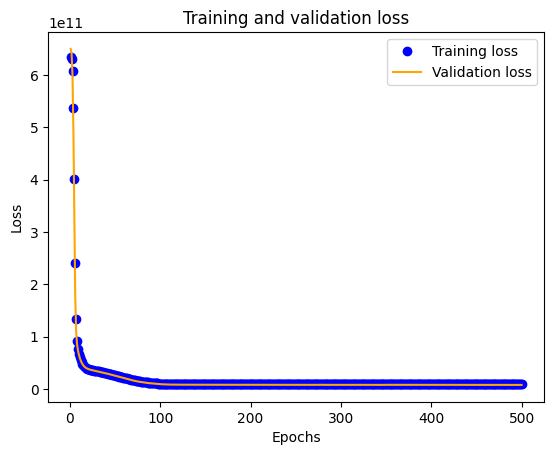

In [14]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

32/32 [==============================] - 0s 6ms/step


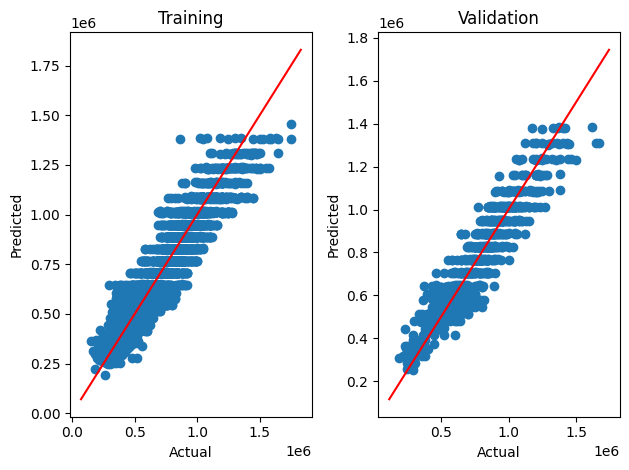

In [15]:
# scatterplot of actual vs. pred
# specify the dimensions 
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=model.predict(X_train)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=model.predict(X_test)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [16]:
# metrics
pred = model.predict(X_test)
pred

trainpreds = model.predict(X_train)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, trainpreds)) # train
print(mean_absolute_error(y_test, pred)) # test

126/126 [==============================] - 0s 2ms/step
70673.43051754168
67068.76935634328


In [17]:
from keras.layers import Dense, Dropout

# Insert the dropout layer
model = Sequential()
model.add(Dense(120, input_shape=(X_train.shape[1],), activation='relu')) # (features,)
model.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5)) # specify a percentage between 0 and 0.5, or larger
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 120)               600       
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_9 (Dense)             (None, 60)                7260      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_10 (Dense)            (None, 30)                1830      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [18]:
# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es],
                    epochs=500,
                    batch_size=32,
                    verbose=1)

Epoch 1/500
126/126 [==============================] - 3s 10ms/step - loss: 633647333376.0000 - mae: 755054.0625 - val_loss: 649705488384.0000 - val_mae: 764446.0625
Epoch 2/500
126/126 [==============================] - 1s 5ms/step - loss: 628735148032.0000 - mae: 751696.6250 - val_loss: 634524336128.0000 - val_mae: 754151.6250
Epoch 3/500
126/126 [==============================] - 1s 4ms/step - loss: 585652305920.0000 - mae: 721136.1875 - val_loss: 549606129664.0000 - val_mae: 693555.8125
Epoch 4/500
126/126 [==============================] - 0s 4ms/step - loss: 448172163072.0000 - mae: 612341.2500 - val_loss: 354200518656.0000 - val_mae: 527227.7500
Epoch 5/500
126/126 [==============================] - 0s 4ms/step - loss: 256010846208.0000 - mae: 424728.8125 - val_loss: 168725872640.0000 - val_mae: 334191.2500
Epoch 6/500
126/126 [==============================] - 1s 5ms/step - loss: 151608000512.0000 - mae: 313169.3750 - val_loss: 102427189248.0000 - val_mae: 261830.1562
Epoch 7/5

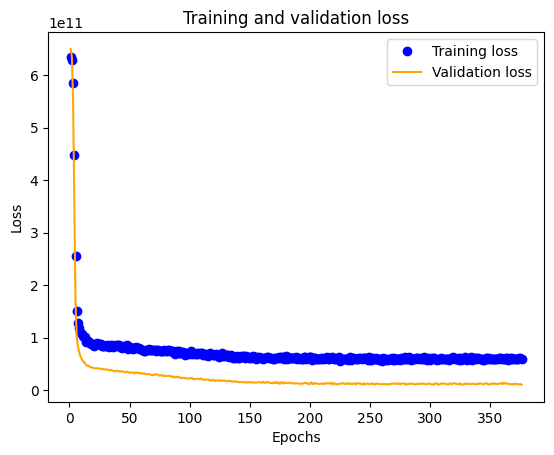

In [19]:
# let's see the training and validation accuracy by epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

32/32 [==============================] - 0s 6ms/step


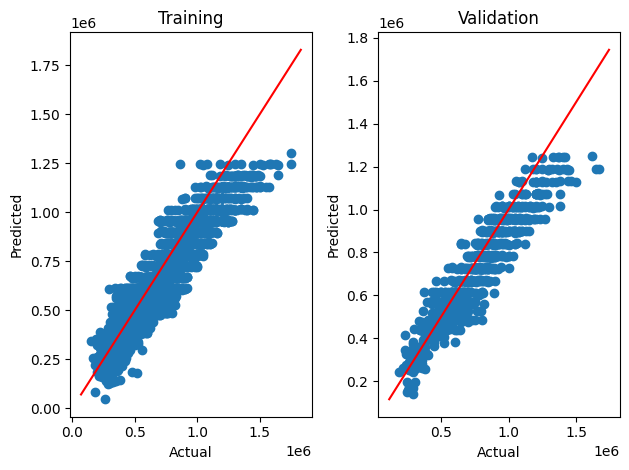

In [20]:
# scatterplot of actual vs. pred
# specify the dimensions 
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
axes[0].scatter(x=y_train, y=model.predict(X_train)) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=model.predict(X_test)) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [21]:
# metrics
pred = model.predict(X_test)
pred

trainpreds = model.predict(X_train)

from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, trainpreds)) # train
print(mean_absolute_error(y_test, pred)) # test

126/126 [==============================] - 0s 3ms/step
79860.75436014867
76781.81509639304
